# Importing Libraries

In [70]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from bs4 import BeautifulSoup
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

# Importing Datasets

The Kaggle competition provides a training dataset and a testing dataset to use. The datasets are made of real tweets, and will require pre-processing steps before any training step.

In [4]:
# Import Train Test set
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA

Printing Unique Keywords

In [6]:
keywords = set(train['keyword'].tolist())
print(keywords)

{nan, 'armageddon', 'fatalities', 'burning', 'derailed', 'cyclone', 'smoke', 'hijacking', 'snowstorm', 'demolition', 'collide', 'demolish', 'hazard', 'sunk', 'evacuated', 'mudslide', 'body%20bagging', 'hijacker', 'death', 'lightning', 'panicking', 'burned', 'destruction', 'rescued', 'harm', 'body%20bags', 'attack', 'destroy', 'army', 'electrocuted', 'meltdown', 'quarantined', 'flooding', 'landslide', 'bioterrorism', 'screamed', 'fatality', 'forest%20fires', 'mass%20murder', 'cliff%20fall', 'casualties', 'aftershock', 'inundated', 'stretcher', 'terrorism', 'structural%20failure', 'first%20responders', 'drowning', 'burning%20buildings', 'detonation', 'bush%20fires', 'drown', 'hazardous', 'hostages', 'refugees', 'weapons', 'exploded', 'ablaze', 'injury', 'survive', 'suicide%20bomber', 'apocalypse', 'bloody', 'destroyed', 'displaced', 'rescue', 'deluge', 'emergency%20services', 'crush', 'hurricane', 'demolished', 'panic', 'obliteration', 'catastrophic', 'mass%20murderer', 'trauma', 'surviv

Dataset info

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Null counts for each feature in each dataset

In [10]:
# null count
print("Null counts for train dataset:")
print(train.isna().sum())
print("Null counts for test dataset:")
print(test.isna().sum())

Null counts for train dataset:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Null counts for test dataset:
id             0
keyword       26
location    1105
text           0
dtype: int64


Plotting Null counts by dataset

Text(0.5, 1.0, 'NaN Counts by Dataset')

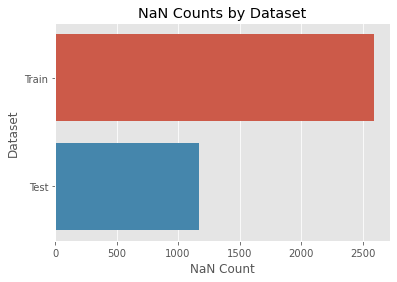

In [35]:
# plot null count by dataset
train_null_count = int(train['keyword'].isna().sum()) + int(train['location'].isna().sum())
test_null_count = int(train['keyword'].isna().sum()) + + int(test['location'].isna().sum())

nullcount = [["Train", train_null_count], ["Test", test_null_count]]
nulldf = pd.DataFrame(nullcount, columns = ["Dataset", "NaN Count"])

plt.style.use('ggplot')

sns.barplot(x='NaN Count', y='Dataset', data = nulldf)
plt.title('NaN Counts by Dataset')

Plotting Null counts by feature

Text(0.5, 1.0, 'NaN Counts by Feature')

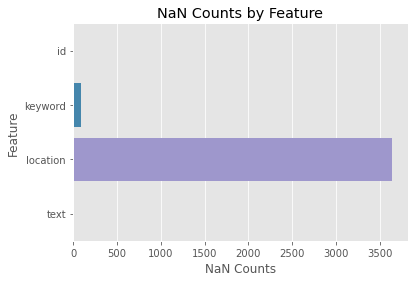

In [37]:
# count null values by feature
counts = []

for i in range(len(train.columns) - 1):
    counts.append(0)
for i in range(len(train.columns) - 1):
    counts[i] += train[train.columns[i]].isna().sum()
    counts[i] += test[test.columns[i]].isna().sum()

# build dataframe for nan counts
d = {"Feature": train.columns[:len(train.columns)-1], "NaN Counts": counts}
null_feat_df = pd.DataFrame(data=d)

# plotting 
plt.style.use('ggplot')
sns.barplot(x='NaN Counts', y='Feature', data = null_feat_df)
plt.title('NaN Counts by Feature')

Each tweet gets classified as a disaster tweet or not, which is represented as a binary value

C:\Users\Aaron\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Target Class Label Count')

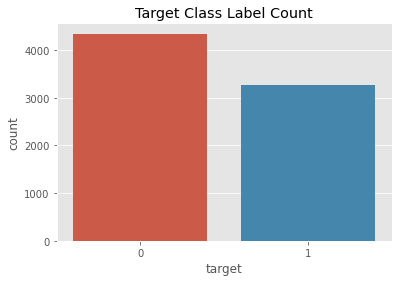

In [40]:
# plot target label count
plt.style.use('ggplot')

sns.countplot('target', data = train)
plt.title('Target Class Label Count')

A WordCould Image of the keywords feature. Bigger words represent higher occurance in the dataset

In [41]:
# generate wordcloud image of keywords
keys = train['keyword'].dropna().tolist()

for i in range(len(keys)):
    keys[i] = keys[i].replace("%20", ' ')
    
keys = ' '.join(keys)

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

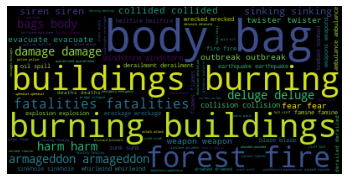

In [42]:
wordcloud = WordCloud().generate(keys)
plt.imshow(wordcloud)
plt.axis('off')
plt.imshow

Analyzing the stop word count

In [45]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# count stopwords in train/test
stopwords= stopwords.words('english')

train_text = train['text'].tolist()
test_text = test['text'].tolist()

tot_train_ctr = 0
tot_test_ctr = 0
train_ctr = 0
test_ctr = 0

for i in range(len(train_text)):
    words = train_text[i].split()
    for word in words:
        if word in stopwords:
            train_ctr += 1
        tot_train_ctr += 1
for i in range(len(test_text)):
    words = test_text[i].split()
    for word in words:
        if word in stopwords:
            test_ctr += 1
        tot_test_ctr += 1

# get the ratio of stop words to total words
print("Ratio of stop words in train set: ", train_ctr / tot_train_ctr)
print("Ratio of stop words in test set: ", test_ctr / tot_test_ctr)

Ratio of stop words in train set:  0.25155780400313765
Ratio of stop words in test set:  0.2466005897771953


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Approx. 25% of all words in both the training and test sets are made of stop words (irrelevant words). In order to create more accurate embeddings, we'll have to get rid of all the irrelevant words. This will greatly help for appraoches that use word embeddings/vectorization. 

# Pre-Processing

Helper Functions to apply on the text feature of the dataframe

First, a function to expand all contractions in text

In [49]:
import contractions # expands contractions (ex: I'll => I will)

In [50]:
def contraction_expand(df):
    return contractions.fix(df)

Next, a function to convert text to lower case

In [51]:
def lowercase_text(df):
    return df.lower()

A function to cast everything to a string type

In [52]:
def string_text(df):
    return str(df)

A function to remove twitter handles

In [53]:
def remove_user(df):
    return re.sub('@[^\s]+','', df)

A function to remove links

In [54]:
def remove_link(df):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , df)

A function to remove all emails

In [55]:
def remove_email(df):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", df)

A function to remove retweets

In [56]:
def remove_rt(df):
    return re.sub(r'\brt\b', "", df).strip()

A function to strip all text of leading and trailing white space

In [58]:
def strip_text(df):
    return df.strip()

A function to remove special characters

In [60]:
def remove_special_chars(df):
    df = re.sub(r'[^\w]+', " ", df)
    df = ' '.join(df.split())
    return df

A driver function to apply all the preprocessing steps at once onto a dataframe

In [61]:
def clean_data(df):
    df = string_text(df)
    df = contraction_expand(df)
    df = lowercase_text(df)
    df = remove_email(df)
    df = remove_link(df)
    df = remove_rt(df)
    df = remove_user(df)
    df = strip_text(df)
    return df

Apply the driver function onto the train and test sets

In [66]:
train['text'] = train['text'].apply(clean_data)
test['text'] = test['text'].apply(clean_data)
train['keyword'] = train['keyword'].apply(clean_data)
test['keyword'] = test['keyword'].apply(clean_data)

Apply the special characters function on the train and test set

In [68]:
train['text'] = train['text'].apply(remove_special_chars)
test['text'] = test['text'].apply(remove_special_chars)
train['keyword'] = train['keyword'].apply(remove_special_chars)
test['keyword'] = test['keyword'].apply(remove_special_chars)

Remove all digits from the train and test set

In [71]:
# Replacing digit characters with empty strings
train['text'] = train['text'].str.replace('\d+', '')
test['text'] = test['text'].str.replace('\d+', '')
train['keyword'] = train['keyword'].str.replace('\d+', '')
test['keyword'] = test['keyword'].str.replace('\d+', '')

Remove all stop words

In [72]:
# python module based of Numpy and Scipy for NLP preprocessing
from gensim.parsing.preprocessing import STOPWORDS
# handy function for removing stopwords
# simply have to apply this function to the dataset
from gensim.parsing.preprocessing import remove_stopwords

In [73]:
#remove stopwords from the train/test set
train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

The id feature is irrelevant for this problem, so we can ignore it. The location feature contains the most amount of NaN values, so we can just ignore it. 

The keyword feature is a feature that indicates the most relevant word in the tweet. Basically it is the word that would indicate that a given tweet is a potential diaster tweet. There are a multiple ways to deal with this feature. The two ways I will try is first to ignore the keword feature entirely, and then to try and combine the keyword and text features (concatenate the keyword onto the tweet's text). It will be interesting to see how different the results will be, if at all. 


Merge keyword and text features into one content feature. We'll only merge keywords and text if the keyword is not a NaN. If it is, we don't need to do anything

In [89]:
train_content = train['text'].tolist()
test_content = test['text'].tolist()

train_keywords = train['keyword'].tolist()
test_keywords = test['keyword'].tolist()

for i in range(len(train_keywords)):
    if train_keywords[i] != "nan":
        train_content[i] = train_keywords[i] + " " + train_content[i]
    
for i in range(len(test_keywords)):
    if test_keywords[i] != "nan":
        test_content[i] = test_keywords[i] + " " + test_content[i]
    
train['content'] = train_content
test['content'] = test_content

### Word Embeddings

One common and effective approach to NLP classification problems is to create word embeddings. There are multiple ways to create word embeddings. The two ways I will use is the CountVectorizer and the TF-IDF Vectorizer. 

**Count Vectorizer**

**TF-IDF Vectorizer**

In [93]:
text_corpus = train['text']
content_corpus = train['content']